In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

##分解(decomposing) 可以用来把时序数据中的趋势和周期性数据都分离出来:
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
Data = pd.read_csv('./world.csv', index_col=0)
#增加id递增列
Data = Data.reset_index()
##该步骤很重要！！建立时序数据
#Parse strings to datetime type  将字符串解析为datetime类型
#convert from string to datetime ###Name: date, dtype: datetime64[ns]
Data['日期']= pd.to_datetime(Data['日期'],infer_datetime_format=True) 
#set_index( ) 将 DataFrame 中的列转化为行索引
indexedDataset = Data.set_index(['日期'])
#数据反转
indexedDataset = indexedDataset.iloc[::-1]
indexedDataset


,confirmedCount
日期,
2020-01-20,282
2020-01-21,314
2020-01-22,581
2020-01-23,844
2020-01-24,1312
2020-01-25,2015
2020-01-26,2801
2020-01-27,4579
2020-01-28,6061


D:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


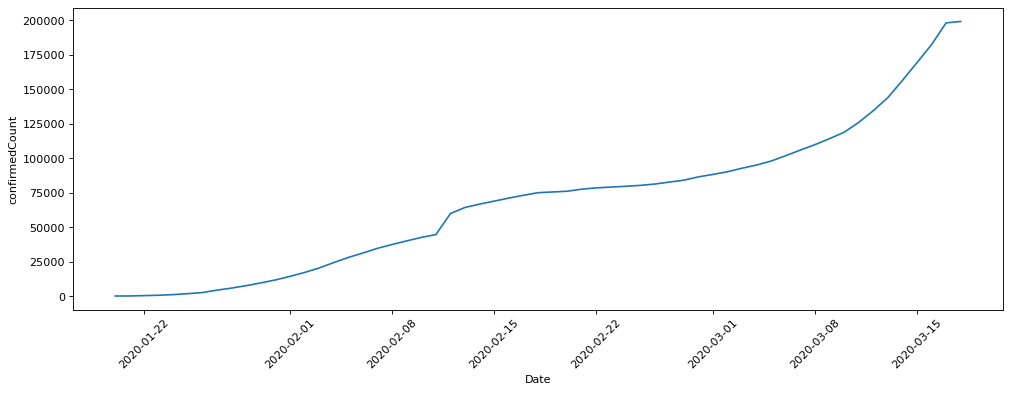

In [3]:

# plot graph
#设置画布大小
plt.figure(figsize=(15,5),dpi = 80)
#横轴坐标旋转45°
plt.xticks(rotation=45)


plt.xlabel('Date')
plt.ylabel('confirmedCount')
plt.plot(indexedDataset)

在使用很多时间序列模型的时候，如 ARMA、ARIMA，都会要求时间序列是平稳的，所以一般在研究一段时间序列的时候，第一步都需要进行平稳性检验，除了用肉眼检测的方法，另外比较常用的严格的统计检验方法就是ADF检验，也叫做单位根检验。

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


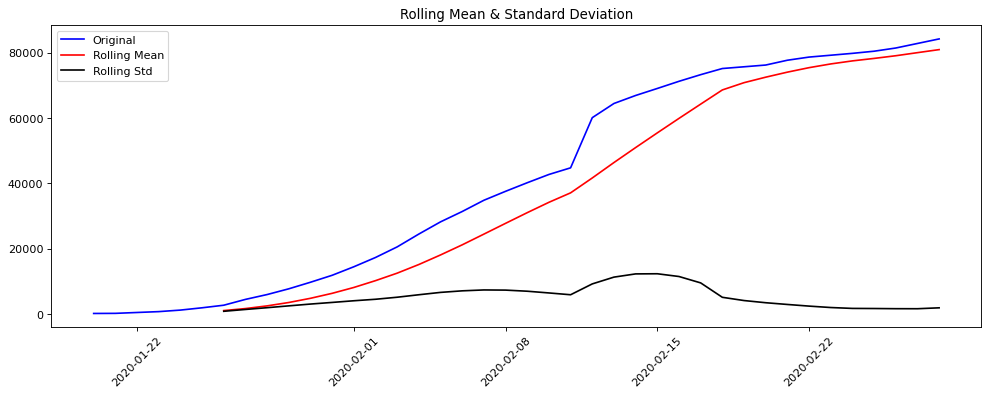

In [4]:
#我们选择前40天数据
indexedDataset = indexedDataset.head(40)
rolmean = indexedDataset.rolling(window=7).mean() #以星期为单位给出滚动平均值
rolstd = indexedDataset.rolling(window=7).std()#以星期为单位给出滚动标准差
#print(rolmean,rolstd)

#Plot rolling statistics

#设置画布大小
plt.figure(figsize=(15,5),dpi = 80)
#横轴坐标旋转45°
plt.xticks(rotation=45)

orig = plt.plot(indexedDataset.ix[:,0], color='blue', label='Original')#原数据
mean = plt.plot(rolmean, color='red', label='Rolling Mean')#平均值
std = plt.plot(rolstd, color='black', label='Rolling Std')#标准差

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

我们需要确保两个滚动的统计数据即:平均值和std. dev.保持时不变或随时间不变。因此，它们的曲线都必须与x轴平行。
所以我们的数据是不平稳的。   

为了进一步增强时间序列不是平稳的假设，让我们进行ADCF测试。  


单位根检验是指检验序列中是否存在单位根，因为存在单位根就是非平稳时间序列了。单位根就是指单位根过程，可以证明，序列中存在单位根过程就不平稳，会使回归分析中存在伪回归。

ADF检验全称是 Augmented Dickey-Fuller test

ADF检验就是判断序列是否存在单位根：如果序列平稳，就不存在单位根；否则，就会存在单位根。
所以，ADF检验的 H0 假设就是存在单位根，如果得到的显著性检验统计量小于三个置信度（10%，5%，1%），则对应有（90%，95，99%）的把握来拒绝原假设。

* from statsmodels.tsa.stattools import adfuller  

adfuller函数的参数意义分别是：

    x：一维的数据序列。
    maxlag：最大滞后数目。
    regression：回归中的包含项（c：只有常数项，默认；ct：常数项和趋势项；ctt：常数项，线性二次项；nc：没有常数项和趋势项）
    autolag：自动选择滞后数目（AIC：赤池信息准则，默认；BIC：贝叶斯信息准则；t-stat：基于maxlag，从maxlag开始并删除一个滞后直到最后一个滞后长度基于 t-statistic 显著性小于5%为止；None：使用maxlag指定的滞后）
    store：True  False，默认。
    regresults：True 完整的回归结果将返回。False，默认。

返回值意义为：

    adf：Test statistic，T检验，假设检验值。
    pvalue：假设检验结果。
    usedlag：使用的滞后阶数。
    nobs：用于ADF回归和计算临界值用到的观测值数目。
    icbest：如果autolag不是None的话，返回最大的信息准则值。
    resstore：将结果合并为一个dummy。
————————————————
版权声明：本文为CSDN博主「敲代码的quant」的原创文章，遵循 CC 4.0 BY-SA 版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/FrankieHello/article/details/86766625

In [5]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['confirmedCount'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -0.111105
p-value                         0.948321
#Lags Used                      0.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


*对于一个时间序列是平稳的，它的ADCF测试应该有:
* p值【p-value】较低(根据原假设)
* 1%、5%、10%置信区间的临界值【Critical Value】应尽可能接近测试统计数据【Test Statistic】  
* 从以上ADCF测试结果可以看出，p值(最大值可以是1.0)非常大。  
* 此外，临界值与测试统计数据没有任何接近之处。因此，我们可以有把握地说，我们的时间序列在此刻是不平稳的。

### 三、时序数据变换，获得稳定性数据  

#### 3.1构建稳定性检验函数：  
    #滑动平均值  
    #滑动标准差  
    #Augmented Dickey–Fuller ADF稳定性检验

In [6]:
#构建稳定性检验函数
def test_stationarity(timeseries):  
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()  #滑动平均值
    movingSTD = timeseries.rolling(window=12).std()     #滑动标准差
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:   Augmented Dickey–Fuller ADF稳定性检验
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['confirmedCount'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### 3.2  Differencing差分方法-Timeshift transformation

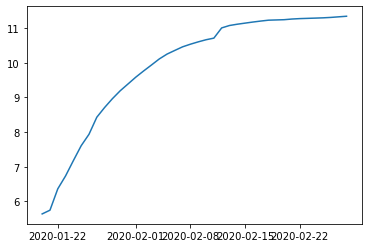

In [7]:
#Estimating trend 估计趋势
indexedDataset_logScale = np.log(indexedDataset)  #taking log 
plt.plot(indexedDataset_logScale)

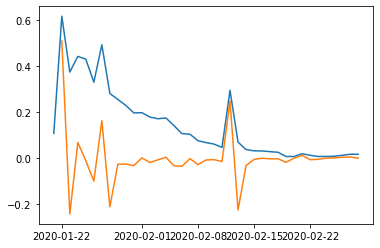

In [8]:
##Differencing--差分
##这里采用的是一阶差分：一阶差分就是离散函数中连续相邻两项之差。
datasetLogDiffShifting_1 = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting_1)

#二阶差分：二阶差分就是一阶差分再进行一次差分。
#注：以下内容可以看出，二阶差分后数据已经稳定，所以ARIMA模型参数d=2。
datasetLogDiffShifting_2 = datasetLogDiffShifting_1 - datasetLogDiffShifting_1.shift()
plt.plot(datasetLogDiffShifting_2)

In [19]:
indexedDataset_logScale

,confirmedCount
日期,
2020-01-20,5.641907
2020-01-21,5.749393
2020-01-22,6.364751
2020-01-23,6.738152
2020-01-24,7.179308
2020-01-25,7.608374
2020-01-26,7.937732
2020-01-27,8.429236
2020-01-28,8.709630


In [20]:
indexedDataset_logScale.shift()

,confirmedCount
日期,
2020-01-20,NaN
2020-01-21,5.641907
2020-01-22,5.749393
2020-01-23,6.364751
2020-01-24,6.738152
2020-01-25,7.179308
2020-01-26,7.608374
2020-01-27,7.937732
2020-01-28,8.429236


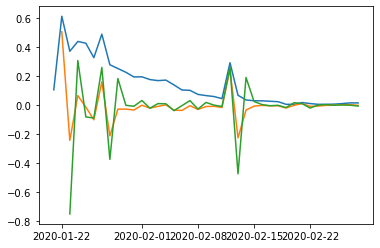

In [9]:
example1 = indexedDataset_logScale.diff(1)
plt.plot(example1)
example2 = example1.diff(1)
plt.plot(example2)
example3 = example2.diff(1)
plt.plot(example3)

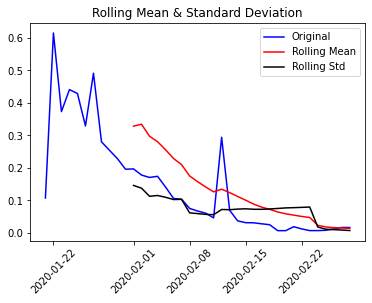

Results of Dickey Fuller Test:
Test Statistic                 -1.981448
p-value                         0.294766
#Lags Used                      1.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [10]:
datasetLogDiffShifting_1.dropna(inplace=True)#滤除缺失数据。
test_stationarity(datasetLogDiffShifting_1)

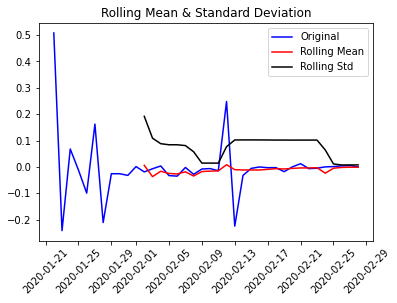

Results of Dickey Fuller Test:
Test Statistic                -7.049674e+00
p-value                        5.568438e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


In [11]:
datasetLogDiffShifting_2.dropna(inplace=True)#滤除缺失数据。
test_stationarity(datasetLogDiffShifting_2)

差分后平稳性都要比原数据好很多。

#### 3.3 MA moving average 移动平均法

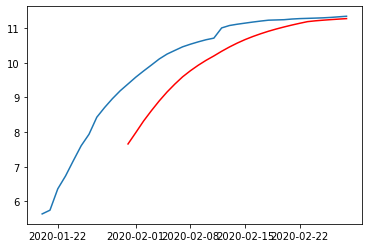

In [12]:
#Estimating trend 估计趋势
indexedDataset_logScale = np.log(indexedDataset)  #taking log 
plt.plot(indexedDataset_logScale)


movingAverage = indexedDataset_logScale.rolling(window=12).mean() #计算log后数据的滑动平均值
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(movingAverage, color='red')

In [21]:
indexedDataset_logScale

,confirmedCount
日期,
2020-01-20,5.641907
2020-01-21,5.749393
2020-01-22,6.364751
2020-01-23,6.738152
2020-01-24,7.179308
2020-01-25,7.608374
2020-01-26,7.937732
2020-01-27,8.429236
2020-01-28,8.709630


In [22]:
movingAverage

,confirmedCount
日期,
2020-01-20,NaN
2020-01-21,NaN
2020-01-22,NaN
2020-01-23,NaN
2020-01-24,NaN
2020-01-25,NaN
2020-01-26,NaN
2020-01-27,NaN
2020-01-28,NaN


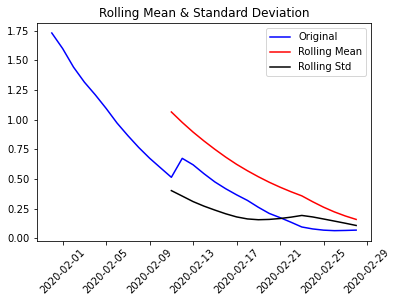

Results of Dickey Fuller Test:
Test Statistic                 -4.976347
p-value                         0.000025
#Lags Used                      0.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


In [13]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
#.dropna() :该函数主要用于滤除缺失数据。如果是Series,则返回一个仅含非空数据和索引值的Series,默认丢弃含有缺失值的行
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
#datasetLogScaleMinusMovingAverage.head(10)
test_stationarity(datasetLogScaleMinusMovingAverage)

#### 3.4 指数加权移动(平均)法 ewm(a)  
     Exponential Decay Transformation  指数衰减转换法    
ewm:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

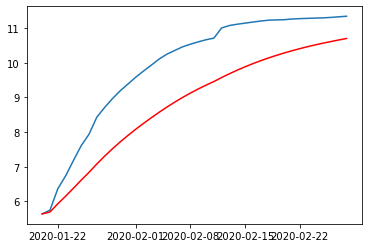

In [14]:
#pandas 指数加权滑动（ewm）, 指数加权滑动平均（ewma）  
# halflife的值决定了衰减因子alpha：  alpha = 1 - exp(log(0.5) / halflife)
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

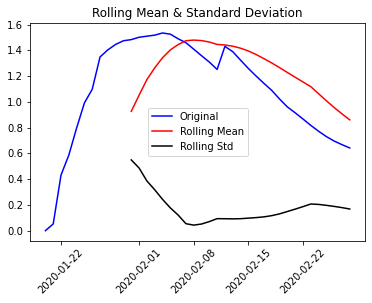

Results of Dickey Fuller Test:
Test Statistic                 -3.081661
p-value                         0.027940
#Lags Used                      0.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


In [15]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

#### 3.5 Decomposing-分解法
#分解(decomposing) 可以用来把时序数据中的趋势和周期性数据都分离出来

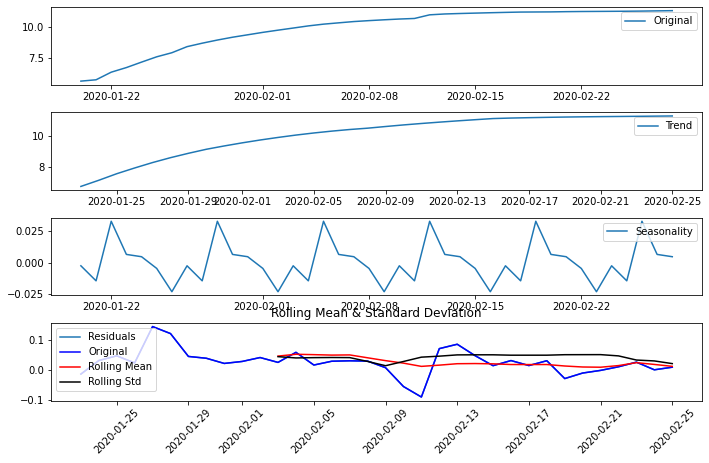

Results of Dickey Fuller Test:
Test Statistic                 -3.586776
p-value                         0.006019
#Lags Used                      1.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


In [16]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

##分解(decomposing) 可以用来把时序数据中的趋势和周期性数据都分离出来:
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6



#Seasonal decomposition using moving averages
## 返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)

'''seasonal_decompose(x, model='additive', filt=None, freq=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages
    
    Parameters
    ----------
    x : array-like
        【Time series】. If 2d, individual series are in columns.'''

decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()#固定布局，tight_layout会自动调整子图参数，使之填充整个图像区域。

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

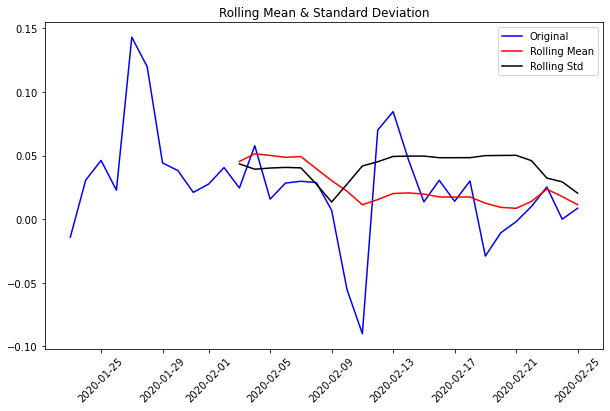

Results of Dickey Fuller Test:
Test Statistic                 -3.586776
p-value                         0.006019
#Lags Used                      1.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


In [17]:
#我们将original数据 拆分成了三份。Trend数据具有明显的趋势性，Seasonality数据具有明显的周期性。


#Residuals是剩余的部分，可以认为是去除了趋势和季节性数据之后，稳定的数据，是我们所需要的。
decomposedLogData = residual #留下稳定的数据
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

### 四、构建模型
#### 4.1 自相关图和偏自相关图的分析

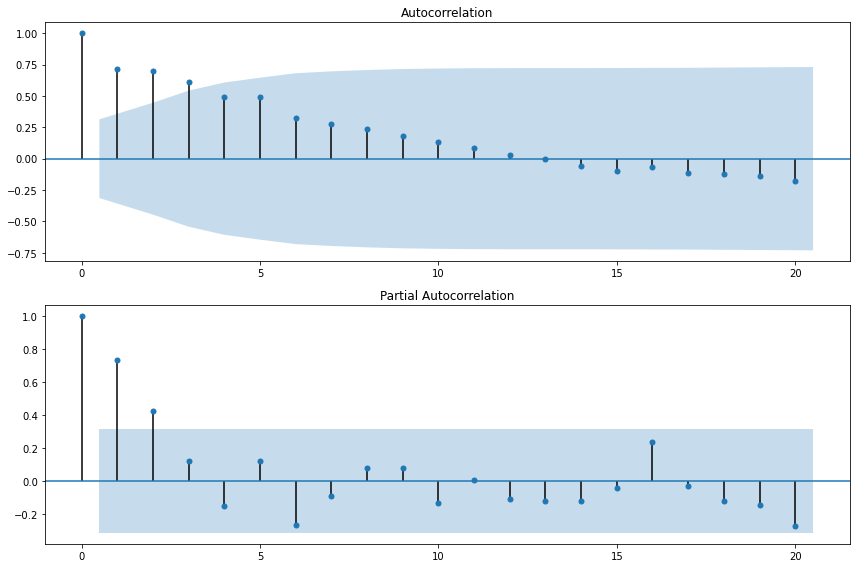

In [18]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
#acf   from statsmodels.tsa.stattools import acf, pacf
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasetLogDiffShifting_1, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#pacf
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasetLogDiffShifting_1, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#下图中的阴影表示置信区间，可以看出不同阶数自相关性的变化情况，从而选出p值和q值